In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import operator
import re
#from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize, pos_tag, pos_tag_sents
import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as ldamodel
from gensim.summarization import summarize
import pyLDAvis.gensim
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from IPython.utils.text import columnize
import warnings
warnings.filterwarnings("ignore")
import textwrap
%matplotlib notebook
plt.style.use('seaborn-darkgrid')



/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#source of iso code database: https://unstats.un.org/unsd/methodology/m49/overview/
##The dataset represents country names as 3-letter ISO-alpha3 Codes.
# To convert these codes into country names, I merged df with UN country names
# This dataset also specifies the region (continent), which I will need later.

df = pd.read_csv('un-general-debates.csv').drop('session', axis=1)
country_names = pd.read_excel('UNSD — Methodology.xlsx')
df = pd.merge(df, country_names[['Region Name','Country or Area','ISO-alpha3 Code']],
             how='left', left_on='country', right_on='ISO-alpha3 Code')
df.drop('ISO-alpha3 Code',axis=1, inplace=True) #removing a duplicate column
df.head()

,year,country,text,Region Name,Country or Area
0,1989,MDV,﻿It is indeed a pleasure for me and the member...,Asia,Maldives
1,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",Europe,Finland
2,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",Africa,Niger
3,1989,URY,﻿\nDuring the debate at the fortieth session o...,Americas,Uruguay
4,1989,ZWE,﻿I should like at the outset to express my del...,Africa,Zimbabwe


In [3]:

# For convenience (processing speed), I will reduce the size of the dataset by:
# 1) Looking at debates that happened this century (years 2001-2015)
df = df.loc[df.year > 2000]
# 2) Limiting the countries of interest to Asian countries:
df = df.loc[df['Region Name'] == 'Africa']
# 3) Removing countries absent from any debates this century:
always_present = [index for (index,value) in 
                      df.country.value_counts().items() 
                  if value==15] # for 15 debates in the 21st century
df = df.loc[df['country'].isin(always_present)]

# The reduced dataframe (number of unique values per column):
df.nunique()

year                15
country             42
text               630
Region Name          1
Country or Area     42
dtype: int64

In [4]:
# Preparing texts for analysis:
def preprocessText(text):
    text = re.sub('[^a-z]+',' ', text.lower()) # remove all non-letter characters
    tokens = word_tokenize(text) # returns a list of individual words
    # Removing unhelpfull, ubiquitous words ('stop words', e.g. ‘the’, ‘is’, ‘are’):
    tokens = [token for token in tokens if len(token) > 4 and
             token not in nltk.corpus.stopwords.words('english')]
    # Lemmatizing removes inflectional endings and gets the root word (lemma):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

df['lemmatized_tokens'] = df['text'].apply(preprocessText)
df['lemmatized_tokens'].head()
df['lemmatized_text'] = [' '.join(x) for x in df['lemmatized_tokens']]
df['freq_dist'] = df['lemmatized_tokens'].apply(FreqDist)
df[['text','lemmatized_tokens','lemmatized_text']].head()


,text,lemmatized_tokens,lemmatized_text
228,Allow me to congratulate \nPresident Ashe on h...,"[allow, congratulate, president, election, pre...",allow congratulate president election preside ...
232,"At the outset, \nI would like, on behalf of th...","[outset, would, behalf, state, government, peo...",outset would behalf state government people co...
234,It is with a heavy heart that \nI address the ...,"[heavy, heart, address, assembly, today, ghana...",heavy heart address assembly today ghana atten...
244,It is an honour and a privilege \nfor me to on...,"[honour, privilege, address, south, africa, at...",honour privilege address south africa attache ...
249,"At the outset, I wish to congratulate \nHis Ex...","[outset, congratulate, excellency, election, p...",outset congratulate excellency election presid...


In [5]:
#african_map =('detailed-map-of-africa-continent-in-black-vector-15726243.png.',delimiter=',', dtype='uint8')


#text = df.lemmatized_text.sum()

# Plotting:
#fig = plt.figure(figsize = (10,10))

#wordcloud = WordCloud(background_color='white',
                      #mask=african_map,
                      #max_words=2000).generate(text);
#plt.imshow(wordcloud, interpolation='bilinear') # plotting the image
#plt.axis("off")

#plt.tight_layout()

In [6]:
# For each word count in how many documents does it appear:

texts = df.lemmatized_tokens.tolist() # I will be working on lemmatized words
all_words = list(set(df.lemmatized_tokens.sum())) # All unique words

texts = [list(set(t)) for t in texts] # Unique words in each text
word_in_texts = {} # keys=unique words, values=the number of texts in which they appear
for word in all_words:
    word_in_texts[word] = 0 
    for text in texts:
        if word in text:
            word_in_texts[word] += 1


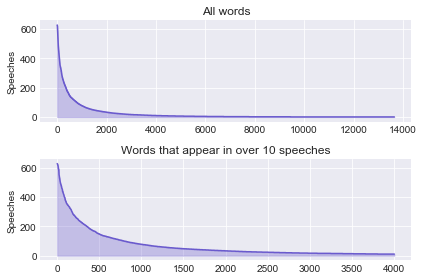

In [7]:

no_of_speeches = len(texts)

fig, ax = plt.subplots(nrows=2, ncols=1) # figure with two subplots

# converting the dicrionary to a list of tupples and sorting them from most common,
# to rarest words
wit = sorted(list(word_in_texts.items()), key=lambda x: x[1], reverse=True)
# for plotting: numbering words from most to liest common:
x_wit = [x for x in range(len(wit))]
y_wit = [y for (x,y) in wit]
ax[0].plot(x_wit, y_wit, color='slateblue')
ax[0].fill_between(x_wit, y_wit, color="slateblue", alpha=0.3)
ax[0].set_title('All words')
ax[0].set_ylabel('Speeches')

# very few words appear in most documents
# on the other hand out of >14,000 unique words
# about 10,000 occur in no more than 10 documents

wit_10 = [x for x in wit if x[1]>10] # remove words appearing in 10 or less documents
x_wit_10 = [x for x in range(len(wit_10))]
y_wit_10 = [y for (x,y) in wit_10]
ax[1].plot(x_wit_10, y_wit_10, color='slateblue')
ax[1].fill_between(x_wit_10, y_wit_10, color="slateblue", alpha=0.3)
ax[1].set_title('Words that appear in over 10 speeches')
ax[1].set_ylabel('Speeches')
plt.tight_layout()

In [8]:
print(columnize([str(x) for x in wit_10[0::25]])) # for a prettier display,
# I put the list into multiple columns

('nation', 627)          ('stronger', 54)         ('recourse', 21)         
('election', 540)        ('associated', 53)       ('prevented', 20)        
('social', 473)          ('celebrate', 52)        ('blueprint', 20)        
('problem', 421)         ('owing', 51)            ('incident', 20)         
('express', 374)         ('accountable', 50)      ('thabo', 19)            
('measure', 346)         ('founded', 49)          ('driving', 19)          
('remain', 324)          ('confronted', 48)       ('tenet', 19)            
('charter', 300)         ('deadline', 47)         ('pretoria', 18)         
('weapon', 277)          ('ambassador', 46)       ('mourning', 18)         
('urgent', 259)          ('seeing', 45)           ('jamahiriya', 18)       
('terrorist', 246)       ('collaboration', 44)    ('unquestionably', 18)   
('access', 232)          ('fraternal', 43)        ('lesotho', 18)          
('present', 222)         ('immense', 43)          ('falling', 17)          
('light', 21